In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Flatten,Input,GlobalAveragePooling1D
from tensorflow.keras.metrics import R2Score,MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler


In [6]:
df=pd.read_csv("my_dataframe.csv")

In [7]:
df.head()

,caseid,dt,result,ppg_tid,ecg_tid,ppg_signal,ecg_signal
0,1,3060.0,154.0,9acbed98f1f15c7827ee3bcc55eaef19f861b824,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,"[37.55433654785156, 37.55433654785156, 37.5543...","[0.879610538482666, 0.879610538482666, 0.87961..."
1,2,152248.0,118.0,8dc8fb6a62bf86f5117e4b5ea679f061c30b8640,62204d727b2e31e42f9602c054c7d9e598b2db05,"[12.275436401367188, 12.275436401367188, 12.27...","[-0.838564395904541, -0.838564395904541, -0.83..."
2,3,NaN,NaN,808aa20f903b14683f5b5fb7ea5a45e53e2117be,2012a9532285255e1051e9be389d69e2778373ba,"[21.36004638671875, 21.36004638671875, 21.3600...","[0.12914323806762695, 0.12914323806762695, 0.1..."
3,4,3078.0,108.0,e8d08e829a45456e8890f47d0995f1b3064529b4,be29325ee538657798f5c804bf72596fb3fd47ea,"[30.049667358398438, 30.049667358398438, 30.04...","[0.7512412071228027, 0.7512412071228027, 0.751..."
4,5,-2968.0,140.0,7cfa86c1b838540f2956240169a83f3723b4092a,3431cd35ca4bc15b6de13e4c49b2db56e6bc5a37,"[40.31922912597656, 40.31922912597656, 40.3192...","[-0.2559647560119629, -0.2559647560119629, -0...."


In [5]:
df.shape

(657, 17)

In [18]:
df.columns

Index(['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)',
       'Weight(kg)', 'Systolic Blood Pressure(mmHg)',
       'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)',
       'Hypertension', 'Diabetes', 'cerebral infarction',
       'cerebrovascular disease', 'BGL Level', 'ECG Level', 'ppg_signal'],
      dtype='object')

In [15]:
def preprocess_health_data(df):
    selected_columns = [2,3,4,5,8,10,15,6,7,14]  # Column indices
    df_selected = df.iloc[:, selected_columns].copy()  # Select columns correctly
    # Label Encoding for Sex (Male = 1, Female = 0)
    df_selected["Sex(M/F)"] = LabelEncoder().fit_transform(df_selected["Sex(M/F)"])
    df_selected["Hypertension"] = LabelEncoder().fit_transform(df_selected["Hypertension"])

    # Convert numerical columns to numeric type and nomralize them
    numeric_cols = [
        "Age(year)", 
        "Height(cm)", 
        "Weight(kg)", 
        "Heart Rate(b/m)", 
        "Systolic Blood Pressure(mmHg)", 
        "Diastolic Blood Pressure(mmHg)",
        "BGL Level",
        "ECG Level",
    ]
    df_selected[numeric_cols] = df_selected[numeric_cols].apply(pd.to_numeric, errors='coerce')
    scaler = MinMaxScaler()
    df_selected[numeric_cols] = scaler.fit_transform(df_selected[numeric_cols])
    df_selected["ppg_signal"]=df["ppg_signal"]
    return df_selected,scaler

In [16]:
df_req,scaler_for_df=preprocess_health_data(df)

In [17]:
df_req.head()

,Sex(M/F),Age(year),Height(cm),Weight(kg),Heart Rate(b/m),Hypertension,ECG Level,Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),BGL Level,ppg_signal
0,0,0.369231,0.137255,0.402985,0.833333,3,0.249022,0.794118,0.723077,0.244627,"[168, 166, 164, 162, 159, 157, 155, 152, 150, ..."
1,0,0.369231,0.137255,0.402985,0.833333,3,0.249022,0.794118,0.723077,0.244627,"[58, 56, 54, 52, 49, 47, 45, 43, 41, 39, 36, 3..."
2,0,0.369231,0.137255,0.402985,0.833333,3,0.249022,0.794118,0.723077,0.244627,"[2, 1, 0, 0, -1, -1, -2, -3, -4, -5, -6, -7, -..."
3,0,0.446154,0.235294,0.208955,0.444444,3,0.354936,0.784314,0.784615,0.425537,"[-8, -8, -8, -8, -8, -8, -9, -9, -9, -9, -9, -..."
4,0,0.446154,0.235294,0.208955,0.444444,3,0.354936,0.784314,0.784615,0.425537,"[-8, -8, -8, -9, -9, -9, -9, -10, -10, -10, -1..."


In [29]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(df, val_size=0.5,test_size=0.2, random_state=42):
    # Convert to NumPy arrays and ensure float32
    ppg_lists = df["ppg_signal"].apply(json.loads).tolist()
    X_ppg = np.stack(ppg_lists, axis=0)
    X_static = df.iloc[:,:9].to_numpy().astype(np.float32)
    y = df["BGL Level"].to_numpy().astype(np.float32)

    # Handle NaNs (replace with 0)
    X_ppg = np.nan_to_num(X_ppg, nan=0.0)
    X_static = np.nan_to_num(X_static, nan=0.0)
    y = np.nan_to_num(y, nan=0.0)

    # Validate and fix PPG shape (ensure 3D: [samples, timesteps, 1])
    if len(X_ppg.shape) == 2:  # If 2D (e.g., [219, 6300])
        X_ppg = X_ppg[..., np.newaxis]  # Add channel dimension: [219, 6300, 1]
    elif len(X_ppg.shape) != 3 or X_ppg.shape[2] != 1:
        raise ValueError(f"PPG data must be 3D with shape (samples, timesteps, 1), got {X_ppg.shape}")

    for i in range(X_ppg.shape[2]):
        X_ppg[:,:,i] = (X_ppg[:,:,i] - X_ppg[:,:,i].mean()) / X_ppg[:,:,i].std()
    # First split: Train vs Temp (val + test)
    X_ppg_train, X_ppg_temp, X_static_train, X_static_temp, y_train, y_temp = train_test_split(
        X_ppg, X_static, y,
        test_size=test_size,
        random_state=random_state
    )

    # Second split: Temp into Val and Test
    X_ppg_val, X_ppg_test, X_static_val, X_static_test, y_val, y_test = train_test_split(
        X_ppg_temp, X_static_temp, y_temp,
        test_size=val_size,
        random_state=random_state
    )

    # Enhanced debugging output
    print("Data Preparation Details:")
    print(f"Input PPG: shape={X_ppg.shape}, dtype={X_ppg.dtype}, sample={X_ppg[0, :5, 0]}")
    print(f"Input Static: shape={X_static.shape}, dtype={X_static.dtype}, sample={X_static[0]}")
    print(f"Input BP: shape={y.shape}, dtype={y.dtype}, sample={y[0]}")
    print("\nSplit Shapes:")
    print(f"Train: PPG={X_ppg_train.shape}, Static={X_static_train.shape}, BP={y_train.shape}")
    print(f"Val: PPG={X_ppg_val.shape}, Static={X_static_val.shape}, BP={y_val.shape}")
    print(f"Test: PPG={X_ppg_test.shape}, Static={X_static_test.shape}, BP={y_test.shape}")

    return (X_ppg_train, X_static_train, y_train,
            X_ppg_val, X_static_val, y_val,
            X_ppg_test, X_static_test, y_test)



In [30]:
X_ppg_train, X_static_train, y_train, \
X_ppg_val, X_static_val, y_val, \
X_ppg_test, X_static_test, y_test = prepare_data(df_req)

Data Preparation Details:
Input PPG: shape=(657, 2100, 1), dtype=int32, sample=[0 0 0 0 0]
Input Static: shape=(657, 9), dtype=float32, sample=[0.         0.36923078 0.13725491 0.40298507 0.8333333  3.
 0.24902198 0.7941176  0.72307694]
Input BP: shape=(657,), dtype=float32, sample=0.24462713301181793

Split Shapes:
Train: PPG=(525, 2100, 1), Static=(525, 9), BP=(525,)
Val: PPG=(66, 2100, 1), Static=(66, 9), BP=(66,)
Test: PPG=(66, 2100, 1), Static=(66, 9), BP=(66,)


In [48]:
class SignalAugmenter(layers.Layer):
    def __init__(self, noise_std=0.05, **kwargs):
        super().__init__(**kwargs)
        self.noise_std = noise_std

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.noise_std)
            return inputs + noise
        return inputs


In [43]:
from tensorflow.keras import layers, Model

def build_bgl_model(dynamic_input_shape=(2100, 1), static_input_shape=(9,)):
    # Input layer
    dynamic_input = layers.Input(shape=dynamic_input_shape,name="dynamic_input")
    
    # Conv Block 1
    x = layers.Conv1D(64, kernel_size=7, activation='relu', padding='same')(dynamic_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Conv Block 2
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    x = layers.Attention(use_scale=True)([x, x])  # Self-attention
    
    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)

     # ----- Static Input Branch -----
    static_input = Input(shape=static_input_shape, name="static_input")  # e.g., age, sex, weight, etc.

    combined = layers.Concatenate()([x, static_input]) 
    
    # Dense layers
    combined = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='linear')(combined)

    # Build model
    model = Model(inputs=[dynamic_input, static_input], outputs=output, name="Enhanced_Model")
    return model


In [44]:
model = build_bgl_model()
model.summary()

Model: "Enhanced_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dynamic_input (InputLayer)    │ (None, 2100, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_11 (Conv1D)            │ (None, 2100, 64)          │             512 │ dynamic_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 2100, 64)          │             256 │ conv1d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_4               │ (None, 1050, 64)          │               0 │ batch_normalization_11[0]… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_12 (Conv1D)            │ (None, 1050, 128)         │          41,088 │ max_pooling1d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 1050, 128)         │             512 │ conv1d_12[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_8               │ (None, 1050, 256)         │         263,168 │ batch_normalization_12[0]… │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_9               │ (None, 1050, 128)         │         164,352 │ bidirectional_8[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_4 (Attention)       │ (None, 1050, 128)         │               1 │ bidirectional_9[0][0],     │
│                               │                           │                 │ bidirectional_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_4    │ (None, 128)               │               0 │ attention_4[0][0]          │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ static_input (InputLayer)     │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 137)               │               0 │ global_average_pooling1d_… │
│                               │                           │                 │ static_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 256)               │          35,328 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 505,474 (1.93 MB)

 Trainable params: 505,090 (1.93 MB)

 Non-trainable params: 384 (1.50 KB)

In [45]:
optimizer = Adam(
    learning_rate=1e-4, 
    weight_decay=1e-6  # Explicit L2 regularization
)

model.compile(
    optimizer=optimizer,
    loss='huber',
    metrics=['mae','mse',MeanAbsolutePercentageError()]
)

callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=10, verbose=1)
]


In [46]:
history = model.fit(
    x={"dynamic_input": X_ppg_train, "static_input": X_static_train},
    y=y_train,
    validation_data=(
        {"dynamic_input": X_ppg_val, "static_input": X_static_val}, y_val
    ),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs={'dynamic_input': '*', 'static_input': '*'}
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 262s 26s/step - loss: 0.2389 - mae: 0.2766 - mean_absolute_percentage_error: 1181386.0000 - mse: 0.1235 - val_loss: 0.2327 - val_mae: 0.2643 - val_mean_absolute_percentage_error: 174.5460 - val_mse: 0.1136 - learning_rate: 1.0000e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 256s 28s/step - loss: 0.2116 - mae: 0.2072 - mean_absolute_percentage_error: 1328113.7500 - mse: 0.0721 - val_loss: 0.2334 - val_mae: 0.2731 - val_mean_absolute_percentage_error: 160.2415 - val_mse: 0.1187 - learning_rate: 1.0000e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 208s 23s/step - loss: 0.2110 - mae: 0.2033 - mean_absolute_percentage_error: 1028686.8750 - mse: 0.0747 - val_loss: 0.2305 - val_mae: 0.2705 - val_mean_absolute_percentage_error: 161.8117 - val_mse: 0.1166 - learning_rate: 1.0000e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 250s 21s/step - loss: 0.2051 - mae: 0.1948 - mean_absolute_percentage_error: 964075.3125 - mse: 0.0668 - val_loss: 0.2276 - val_mae: 0.2679 - val_mean_absolute_perce

In [100]:
print(X_train.shape)
print(y_train.shape)


(6072, 100, 2)
(6072, 1)


In [99]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


In [102]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)


In [50]:
model.save("my_model.keras")

In [51]:
a=4

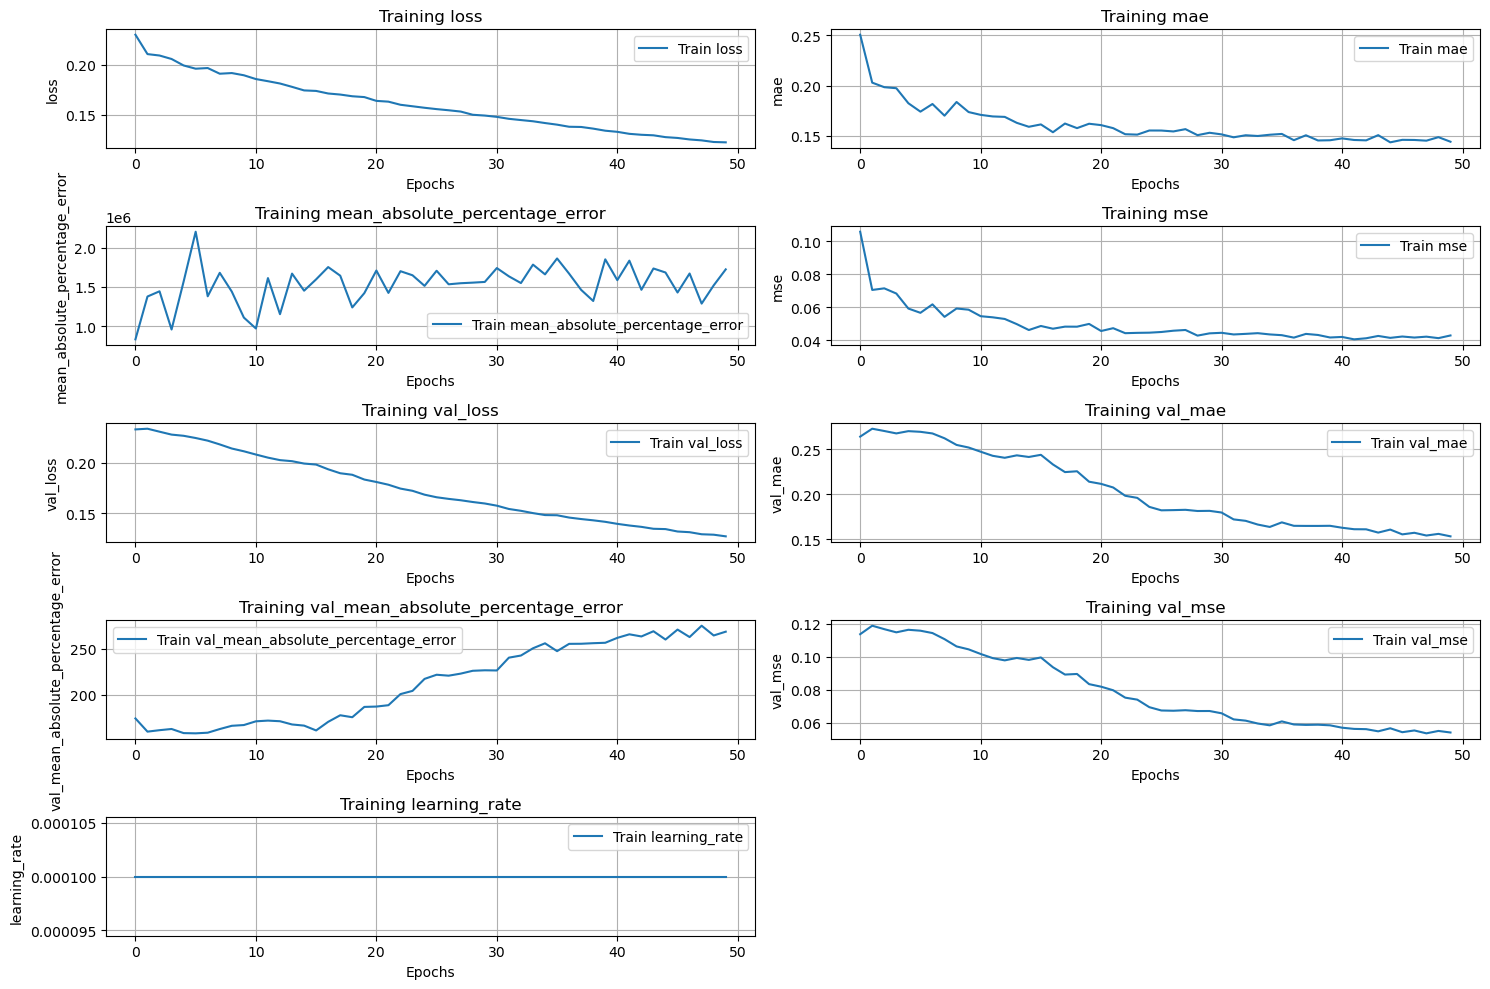

In [52]:
import matplotlib.pyplot as plt

# Assuming you have a Keras History object called `history`
history_dict = history.history

# Create a plot for each metric in the history
plt.figure(figsize=(15, 10))
for i, key in enumerate(history_dict.keys()):
    plt.subplot((len(history_dict) + 1) // 2, 2, i + 1)
    plt.plot(history_dict[key], label=f'Train {key}')
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.title(f'Training {key}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


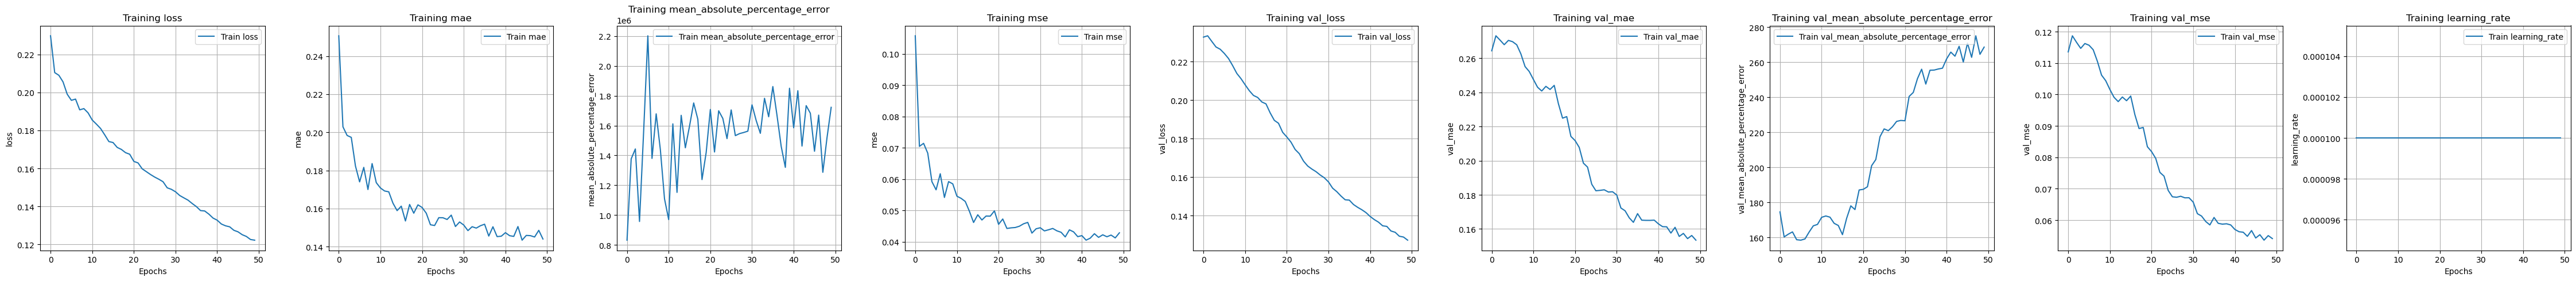

In [53]:
import matplotlib.pyplot as plt

# Assuming you have a Keras History object called `history`
history_dict = history.history
n_metrics = len(history_dict)

# Create a single-row plot for each metric
plt.figure(figsize=(5 * n_metrics, 5))
for i, key in enumerate(history_dict.keys()):
    plt.subplot(1, n_metrics, i + 1)
    plt.plot(history_dict[key], label=f'Train {key}')
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.title(f'Training {key}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


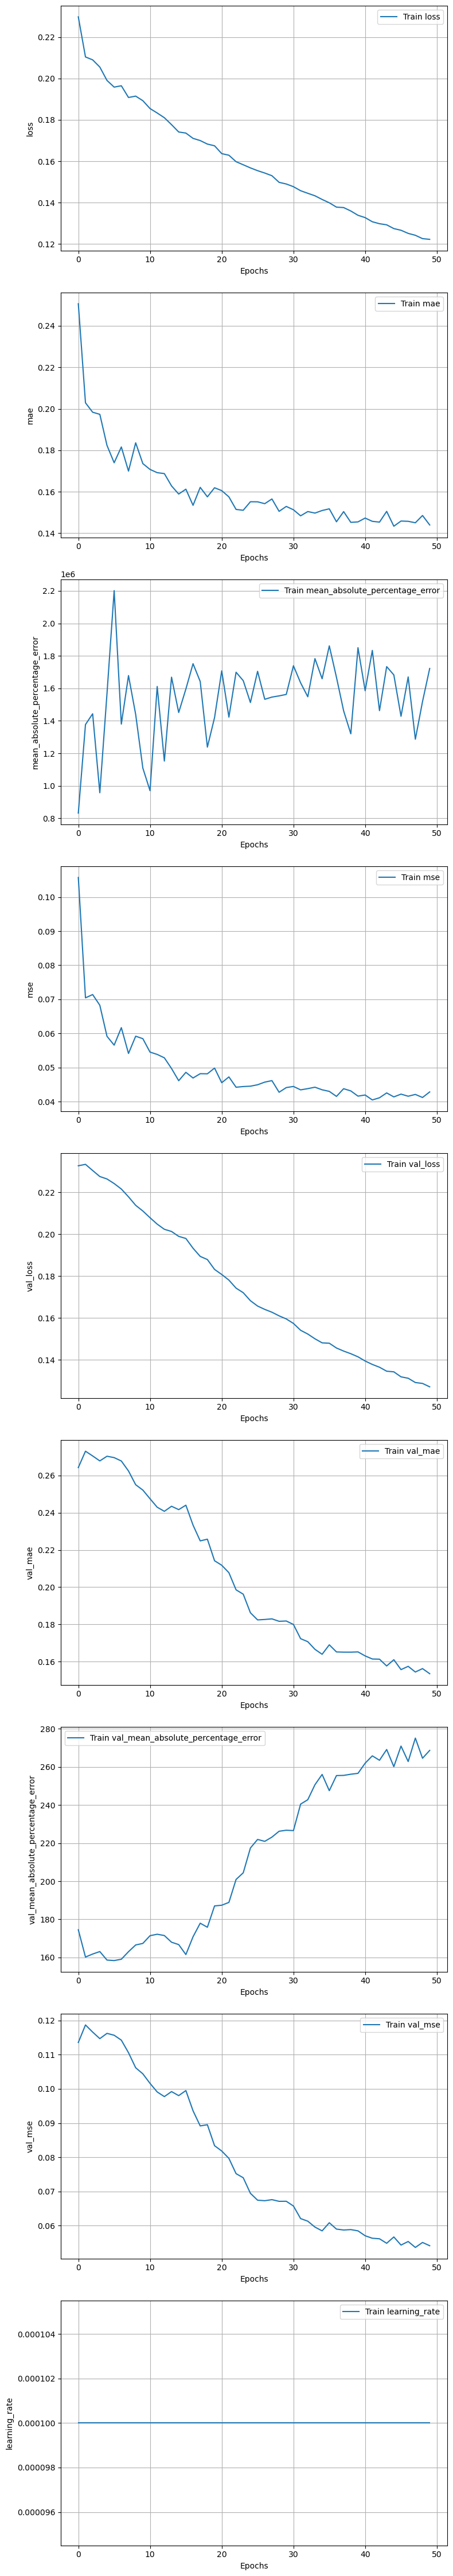

In [55]:
import matplotlib.pyplot as plt

# Assuming you have a Keras History object called `history`
history_dict = history.history
n_metrics = len(history_dict)

# Create a vertical stack of plots (1 column, n rows)
plt.figure(figsize=(8, 5 * n_metrics))
for i, key in enumerate(history_dict.keys()):
    plt.subplot(n_metrics, 1, i + 1)
    plt.plot(history_dict[key], label=f'Train {key}')
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()



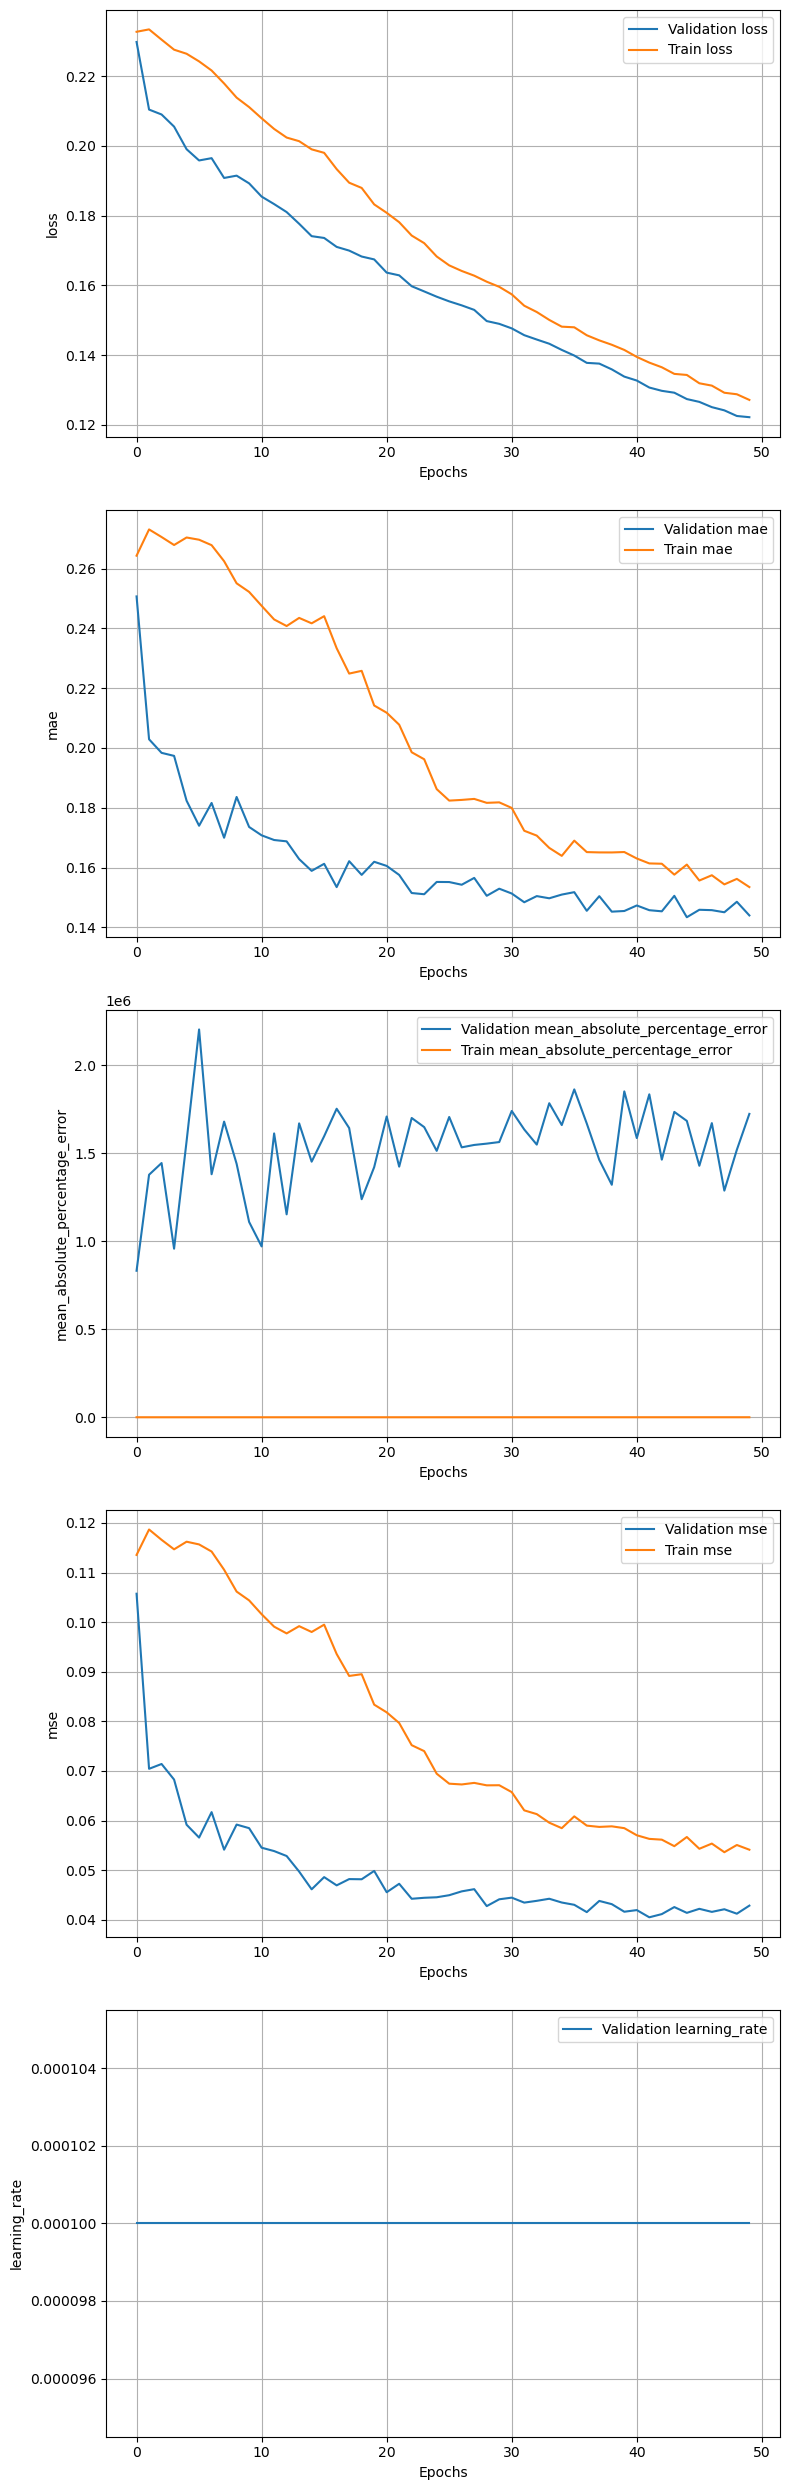

In [58]:
import matplotlib.pyplot as plt

# Assuming you have a Keras History object called `history`
history_dict = history.history

# Get the list of metrics (excluding 'val_' prefixes for comparison)
metrics = [key for key in history_dict.keys() if not key.startswith('val_')]

n_metrics = len(metrics)
plt.figure(figsize=(8, 5 * n_metrics))

for i, metric in enumerate(metrics):
    plt.subplot(n_metrics, 1, i + 1)
    
    # Plot training metric
    plt.plot(history_dict[metric], label=f'Validation {metric}')
    
    # Plot validation metric if available
    val_metric = f'val_{metric}'
    if val_metric in history_dict:
        plt.plot(history_dict[val_metric], label=f'Train {metric}')
    
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [63]:
y_pred = model.predict(
    {"dynamic_input": X_ppg_test, "static_input": X_static_test}
)


C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs={'dynamic_input': '*', 'static_input': '*'}
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [65]:
residuals = y_test - y_pred

In [68]:
y_pred_flat = y_pred.ravel()  # This will flatten y_pred from (66, 1) to (66,)

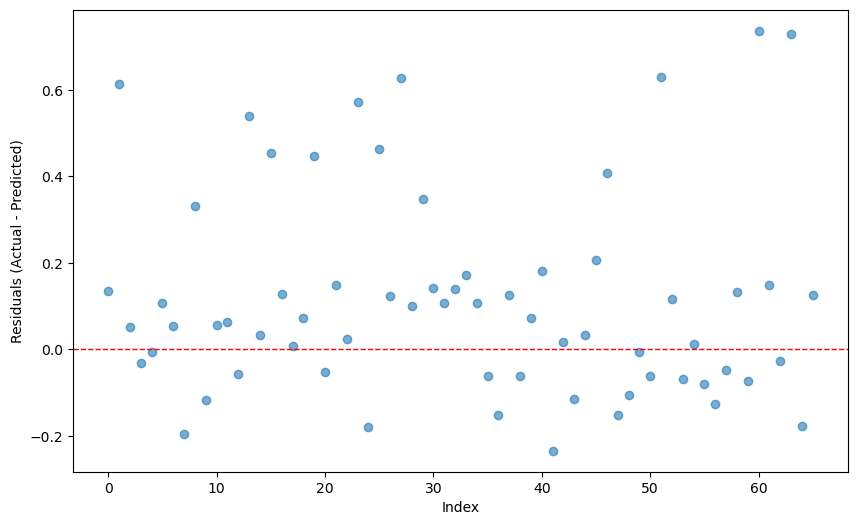

In [73]:
# Calculate residuals
residuals = y_test - y_pred_flat

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Line at 0 for reference
plt.xlabel("Index")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

In [74]:
scaler_for_df

MinMaxScaler()

In [77]:
y_pred_reshaped = y_pred.reshape(-1, 1)

# Apply inverse transform only on the last column (output column)
y_pred_2 = scaler_for_df.inverse_transform(np.hstack([np.zeros((y_pred_reshaped.shape[0], scaler_for_df.scale_.shape[0] - 1)), y_pred_reshaped]))


In [81]:
import numpy as np

# Assuming y_pred has shape (66, 8) and you want to descale the 6th column (7th column in 0-indexing)
# Reshape y_pred if needed (it should be (66, 8), so no reshaping if it's already like this)
y_pred_reshaped = y_pred.reshape(-1, 8)  # If y_pred is not (66, 8), reshape it

# Extract the 6th column (index 6) for descaling
y_pred_6 = y_pred_reshaped[:, 6].reshape(-1, 1)

# Apply inverse transformation to the 6th column only (index 6)
# Create a new array with the same shape, but set all columns except the 6th to zero
y_pred_reshaped[:, 6] = scaler_for_df.inverse_transform(np.hstack([
    np.zeros((y_pred_reshaped.shape[0], scaler_for_df.scale_.shape[0] - 1)),  # Fill other columns with zeros
    y_pred_6  # Keep the 6th column to be descaled
]))[:, -1]  # Only take the last column after inverse transform

# y_pred_reshaped now has the 6th column descaled, while others remain unchanged.


ValueError: cannot reshape array of size 66 into shape (8)

In [82]:
y_pred.shape

(66, 1)

In [87]:
min_6th = scaler_for_df.min_[6]  # min_ is a 1D array, so index 5 corresponds to the 6th column
scale_6th = scaler_for_df.scale_[6]  # scale_ is a 1D array, so index 5 corresponds to the 6th column
y_pred_flat = y_pred.flatten()  # This converts y_pred from shape (66, 1) to shape (66,)

# Descale the 6th index values (using min_ and scale_ for the 6th column)
y_pred_descale_6th = y_pred_flat * scale_6th + min_6th  # Inverse transform for the 6th column


In [88]:
y_pred_descale_6th

array([-0.26245856, -0.26192787, -0.26225975, -0.2622768 , -0.26198617,
       -0.26221052, -0.26204008, -0.26227072, -0.26162648, -0.26224118,
       -0.26210758, -0.26239368, -0.26194212, -0.26246664, -0.26223978,
       -0.26189873, -0.2621165 , -0.2623307 , -0.26213828, -0.26227745,
       -0.26228234, -0.26223275, -0.26197043, -0.2620136 , -0.26238912,
       -0.26194644, -0.2622909 , -0.262247  , -0.26215178, -0.26171073,
       -0.2621832 , -0.2623299 , -0.26247337, -0.26230988, -0.26196992,
       -0.26198557, -0.26197097, -0.26230055, -0.26243383, -0.26213828,
       -0.26223502, -0.2622701 , -0.26229173, -0.26222423, -0.26227915,
       -0.26243475, -0.26205674, -0.26197097, -0.26229462, -0.26232454,
       -0.26243383, -0.26200786, -0.2621965 , -0.26236632, -0.26196393,
       -0.2622764 , -0.2621543 , -0.26232576, -0.26231235, -0.26186016,
       -0.2622767 , -0.26241612, -0.2623372 , -0.26217908, -0.26234087,
       -0.2622432 ], dtype=float32)

In [89]:
scale_6th

0.005071431775682214

In [92]:
# Assuming you already have a fitted MinMaxScaler # Example scaled value
min_value = scaler_for_df.data_min_[6]  # min value for the particular column
max_value = scaler_for_df.data_max_[6]  # max value for the particular column

# Descale the value
y_pred_descaled = y_pred_flat + (scaled_value * (max_value - min_value))


In [93]:
y_pred_descaled

array([98.80805 , 98.91269 , 98.84725 , 98.84389 , 98.9012  , 98.85696 ,
       98.890564, 98.84509 , 98.97212 , 98.850914, 98.87726 , 98.82085 ,
       98.90989 , 98.80646 , 98.85119 , 98.91844 , 98.8755  , 98.83326 ,
       98.8712  , 98.843765, 98.842804, 98.85258 , 98.904305, 98.89579 ,
       98.82175 , 98.909035, 98.84111 , 98.84977 , 98.868546, 98.95551 ,
       98.86235 , 98.83342 , 98.80513 , 98.837364, 98.9044  , 98.90131 ,
       98.9042  , 98.8392  , 98.81293 , 98.8712  , 98.85213 , 98.845215,
       98.84095 , 98.854256, 98.84343 , 98.812744, 98.88728 , 98.9042  ,
       98.84038 , 98.83447 , 98.81293 , 98.89692 , 98.85972 , 98.82623 ,
       98.90558 , 98.84397 , 98.86804 , 98.834236, 98.83688 , 98.92605 ,
       98.84391 , 98.81642 , 98.83198 , 98.86316 , 98.83126 , 98.85051 ],
      dtype=float32)

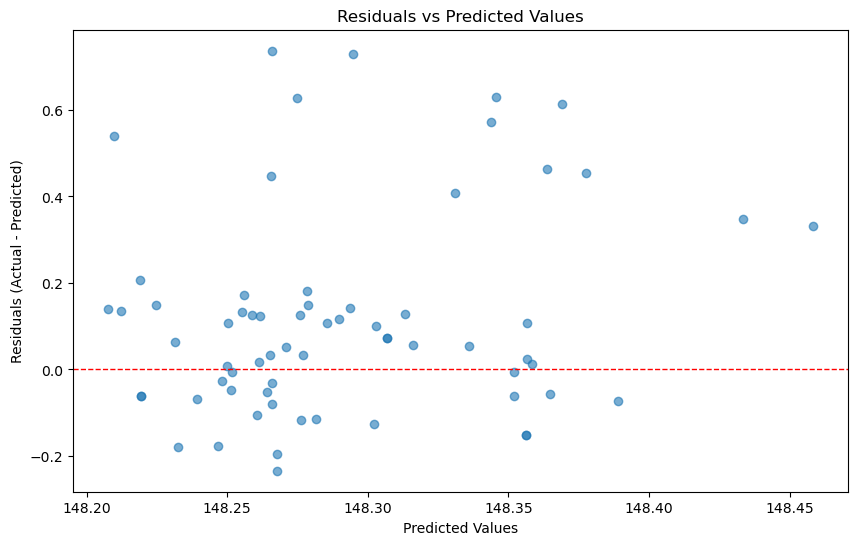

In [97]:
# Flatten y_pred to make it a 1D array
y_pred_flat = y_pred.ravel()
y_pred_descaled=y_pred_flat + (scaled_value * (max_value - min_value))
y_test_descaled=y_test+ (scaled_value * (max_value - min_value))
# Calculate residuals
residuals = y_test_descaled - y_pred_descaled

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_descaled, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Line at 0 for reference
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


In [111]:
 a=model.evaluate(
    {"dynamic_input": X_ppg_test, "static_input": X_static_test},
    y_test
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step - loss: 0.1358 - mae: 0.1870 - mean_absolute_percentage_error: 65.1761 - mse: 0.0714


In [112]:
a

[0.13458168506622314,
 0.18234115839004517,
 0.06892586499452591,
 69.64176940917969]

In [113]:
a[0]=a[0]*(max_value-min_value)+min_value
a[1]=a[1]*(max_value-min_value)+min_value

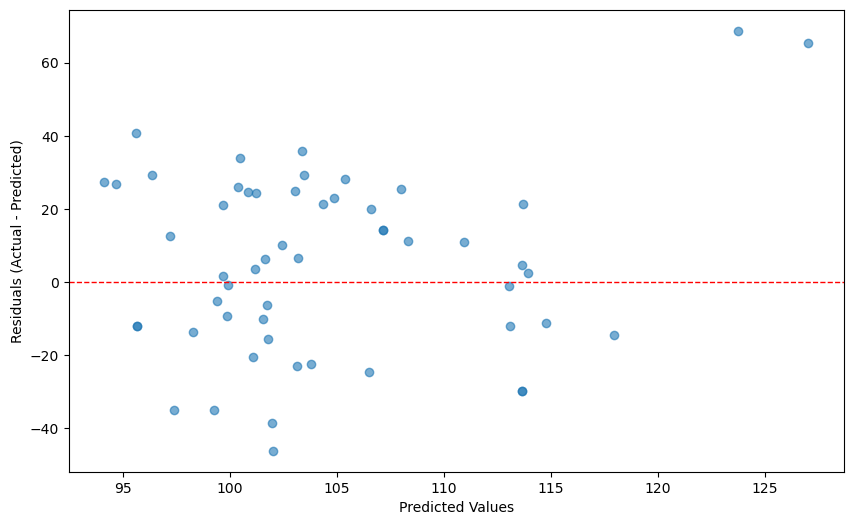

In [109]:
y_pred_descaled=y_pred_flat*(max_value-min_value)+min_value
y_test_descaled=y_test*(max_value-min_value)+min_value
residuals = y_test_descaled - y_pred_descaled
xplot=[]
yplot=[]
for i in range(len(residuals)):
    if residuals[i]<70:
        xplot.append(y_pred_descaled[i])
        yplot.append(residuals[i])
# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(xplot, yplot, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Line at 0 for reference
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


In [103]:
y_pred_descaled

array([ 94.67252 , 115.30563 , 102.402466, 101.739105, 113.03988 ,
       104.31601 , 110.942825, 101.97627 , 127.02399 , 103.123726,
       108.318405,  97.194885, 114.75276 ,  94.35806 , 103.17834 ,
       116.439   , 107.97285 ,  99.64308 , 107.12492 , 101.714355,
       101.524376, 103.45204 , 113.651855, 111.97248 ,  97.37218 ,
       114.584625, 101.19104 , 102.898224, 106.60092 , 123.748825,
       105.378784,  99.67497 ,  94.09677 , 100.45279 , 113.67133 ,
       113.06268 , 113.63063 , 100.81535 ,  95.63382 , 107.12492 ,
       103.36362 , 101.99972 , 101.1588  , 103.78356 , 101.64763 ,
        95.59804 , 110.2959  , 113.63063 , 101.04608 ,  99.88258 ,
        95.63382 , 112.195724, 104.86055 ,  98.25801 , 113.90364 ,
       101.7547  , 106.50177 ,  99.83519 , 100.35736 , 117.93885 ,
       101.74319 ,  96.32235 ,  99.39015 , 105.53894 ,  99.24811 ,
       103.04498 ], dtype=float32)

In [106]:
residuals

array([ 26.763687 , 121.06006  ,  10.165421 ,  -6.2847443,  -1.1222305,
        21.191284 ,  10.902321 , -38.559875 ,  65.45648  , -22.93261  ,
        11.062851 ,  12.513519 , -11.24073  , 106.2702   ,   6.6160965,
        89.734856 ,  25.351555 ,   1.603447 ,  14.318344 ,  88.33771  ,
       -10.16291  ,  29.19197  ,   4.57666  , 112.97619  , -35.166046 ,
        91.58923  ,  24.357903 , 123.884    ,  19.912628 ,  68.73164  ,
        28.16809  ,  21.079231 ,  27.33944  ,  33.77124  ,  21.268578 ,
       -12.123062 , -29.896057 ,  24.69194  , -12.042946 ,  14.318344 ,
        35.84932  , -46.184917 ,   3.5915833, -22.475197 ,   6.398773 ,
        40.79503  ,  80.492676 , -29.896057 , -20.669281 ,  -0.9633713,
       -12.042946 , 124.16997  ,  23.06366  , -13.634598 ,   2.3714523,
       -15.692886 , -24.6996   ,  -9.443008 ,  26.060707 , -14.426819 ,
       145.32358  ,  29.226593 ,  -5.1697235, 143.61295  , -35.131653 ,
        24.879227 ], dtype=float32)

In [107]:
y_pred_descaled

array([ 94.67252 , 115.30563 , 102.402466, 101.739105, 113.03988 ,
       104.31601 , 110.942825, 101.97627 , 127.02399 , 103.123726,
       108.318405,  97.194885, 114.75276 ,  94.35806 , 103.17834 ,
       116.439   , 107.97285 ,  99.64308 , 107.12492 , 101.714355,
       101.524376, 103.45204 , 113.651855, 111.97248 ,  97.37218 ,
       114.584625, 101.19104 , 102.898224, 106.60092 , 123.748825,
       105.378784,  99.67497 ,  94.09677 , 100.45279 , 113.67133 ,
       113.06268 , 113.63063 , 100.81535 ,  95.63382 , 107.12492 ,
       103.36362 , 101.99972 , 101.1588  , 103.78356 , 101.64763 ,
        95.59804 , 110.2959  , 113.63063 , 101.04608 ,  99.88258 ,
        95.63382 , 112.195724, 104.86055 ,  98.25801 , 113.90364 ,
       101.7547  , 106.50177 ,  99.83519 , 100.35736 , 117.93885 ,
       101.74319 ,  96.32235 ,  99.39015 , 105.53894 ,  99.24811 ,
       103.04498 ], dtype=float32)

In [108]:
y_test_descaled

array([121.43621 , 236.36569 , 112.56789 ,  95.45436 , 111.91765 ,
       125.50729 , 121.845146,  63.416397, 192.48047 ,  80.19112 ,
       119.381256, 109.708405, 103.51203 , 200.62827 , 109.79443 ,
       206.17386 , 133.3244  , 101.24653 , 121.44327 , 190.05206 ,
        91.361465, 132.64401 , 118.228516, 224.94867 ,  62.20613 ,
       206.17386 , 125.54894 , 226.78223 , 126.51355 , 192.48047 ,
       133.54688 , 120.7542  , 121.43621 , 134.22403 , 134.93991 ,
       100.93962 ,  83.73457 , 125.50729 ,  83.59087 , 121.44327 ,
       139.21294 ,  55.8148  , 104.75038 ,  81.308365, 108.0464  ,
       136.39307 , 190.78857 ,  83.73457 ,  80.3768  ,  98.91921 ,
        83.59087 , 236.36569 , 127.92421 ,  84.62341 , 116.27509 ,
        86.06181 ,  81.80217 ,  90.39218 , 126.41807 , 103.51203 ,
       247.06677 , 125.54894 ,  94.22043 , 249.15189 ,  64.116455,
       127.92421 ], dtype=float32)

In [114]:
a

[78.50614211446614, 87.92349710144067, 0.06892586499452591, 69.64176940917969]

In [116]:
df2=pd.read_csv("pp_ecg_preprocessedSignalLarge.csv")

In [117]:
df2.shape

(11532, 8)